# 1. Required Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
merged_data = pd.read_csv("MERGED_DOMINOS_DATA.csv")
merged_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187367,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,60.0,3,12,53,2015,0,0
187368,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,100.0,3,12,53,2015,0,0
187369,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,20.0,3,12,53,2015,0,0
187370,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,5.0,3,12,53,2015,0,0


# Train-Test Split

In [3]:
# # Prepareing the Data for Time Series Forecasting
# # Converting order_date to datetime format
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

merged_data = merged_data.set_index('order_date').sort_index()

daily_sales = merged_data['total_price'].resample('D').sum()

print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187372, 18)


In [4]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 252 pizzas
The Big Meat Pizza: 99 pizzas
The Brie Carre Pizza: 48 pizzas
The Calabrese Pizza: 72 pizzas
The California Chicken Pizza: 212 pizzas
The Chicken Alfredo Pizza: 92 pizzas
The Chicken Pesto Pizza: 76 pizzas
The Classic Deluxe Pizza: 117 pizzas
The Five Cheese Pizza: 60 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 155 pizzas
The Green Garden Pizza: 105 pizzas
The Hawaiian Pizza: 135 pizzas
The Italian Capocollo Pizza: 108 pizzas
The Italian Supreme Pizza: 144 pizzas
The Italian Vegetables Pizza: 103 pizzas
The Mediterranean Pizza: 53 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 112 pizzas
The Pepper Salami Pizza: 85 pizzas
The Pepperoni Pizza: 110 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 39 pizzas
The Prosciutto and Arugula Pizza: 65 pizzas
The Sicilian Pizza: 212 pizzas
The Soppressata Pizza: 76 pizzas
The Southwest Chicken Pizza: 205 pizzas
The Spicy Italian Pizza: 159 pizzas
The Spinach

# 7. Exploratory Data Analysis (EDA) - Visualizing Distributions

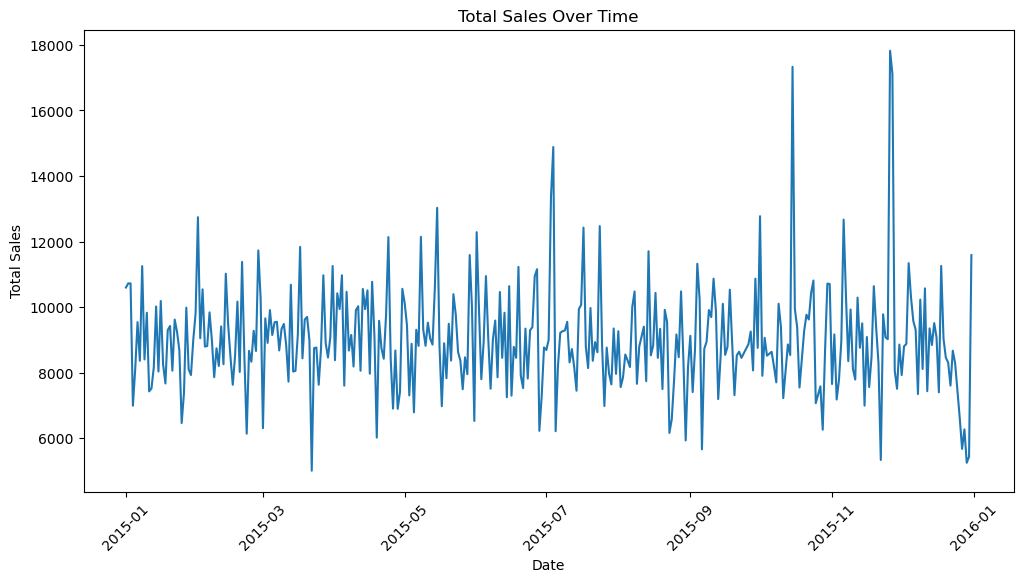

In [6]:
# Analyzing Sales Trends Over Time

# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

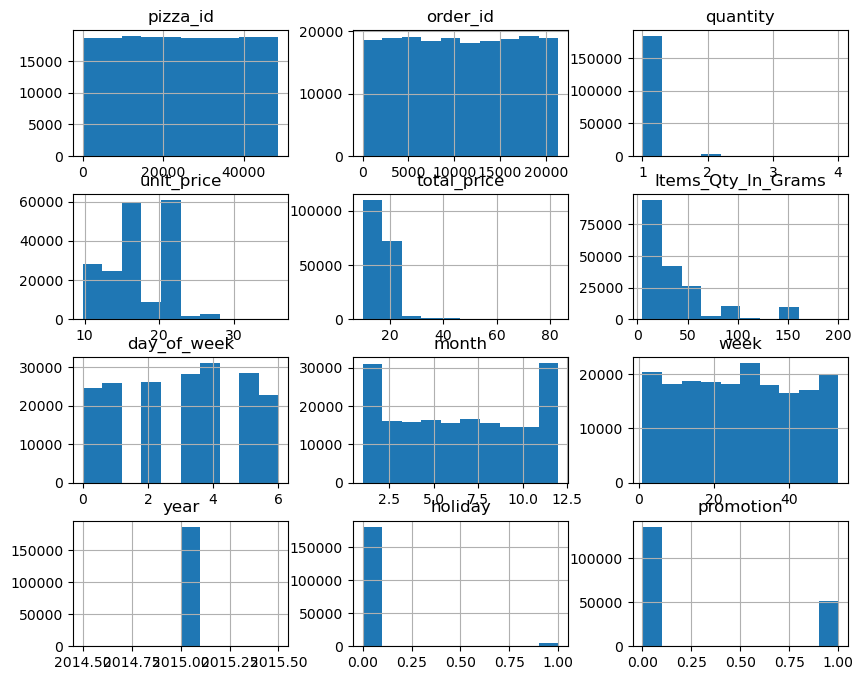

In [7]:
merged_data.hist(figsize=(10,8))
plt.show()

## Top-Selling Pizzas

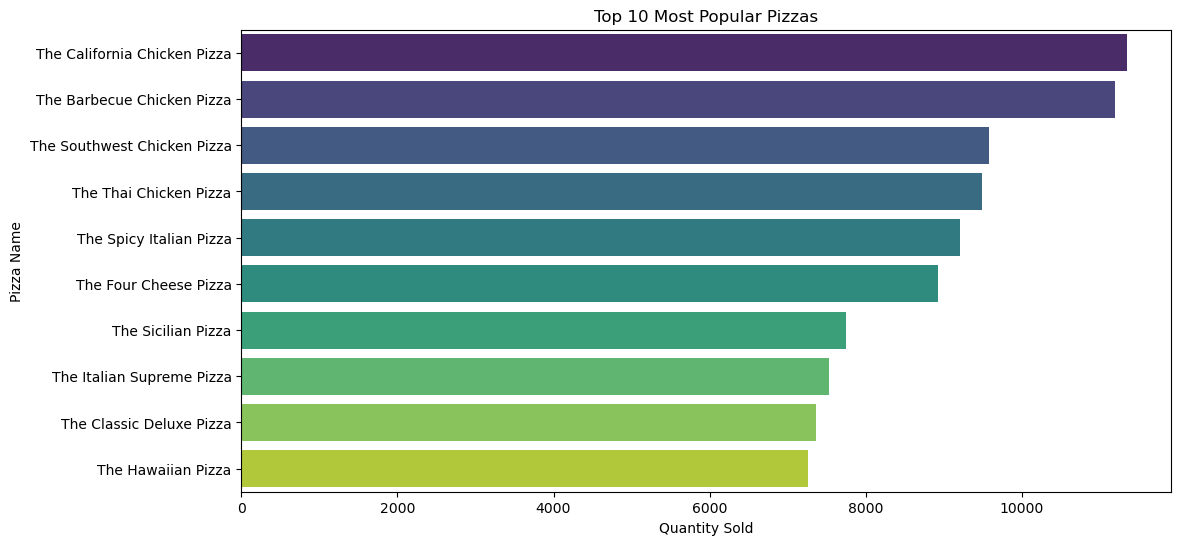

In [8]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

## Sales by Pizza Size and Category

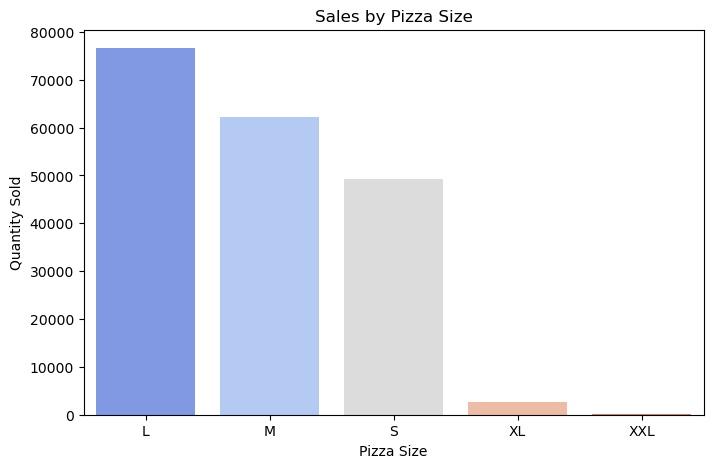

In [9]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

## Sales by Pizza category and quantity

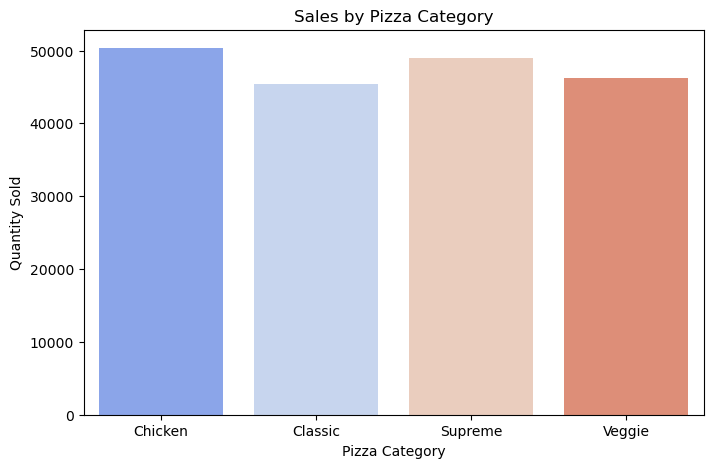

In [10]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

## Seasonal Sales Trends and Patterns

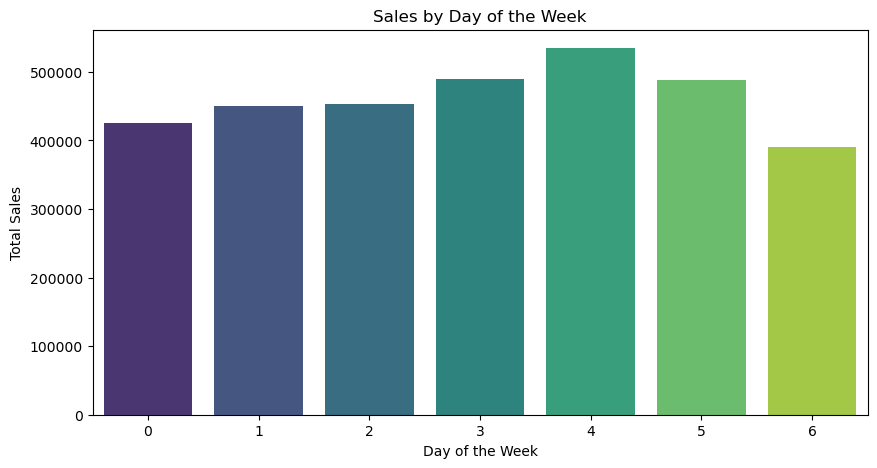

In [11]:
# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

## Sales by Month

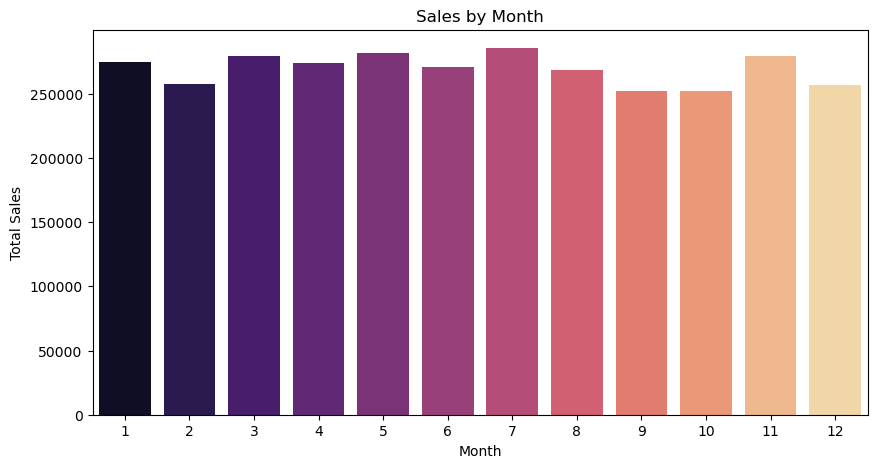

In [12]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

## Correlation Analysis of Sales Metrics

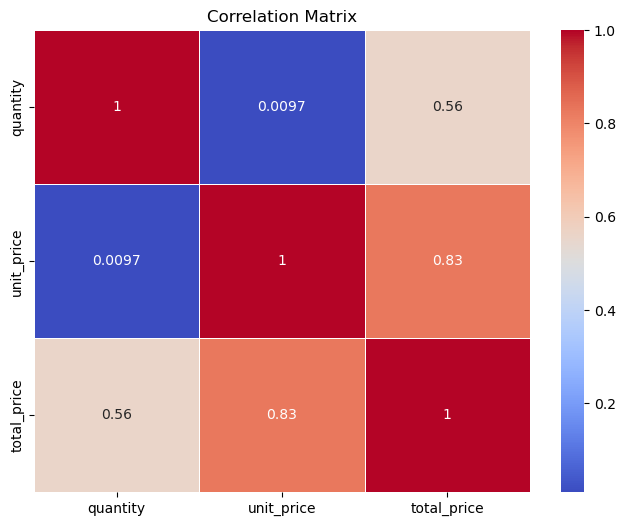

In [13]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Outlier Detection in Sales Data

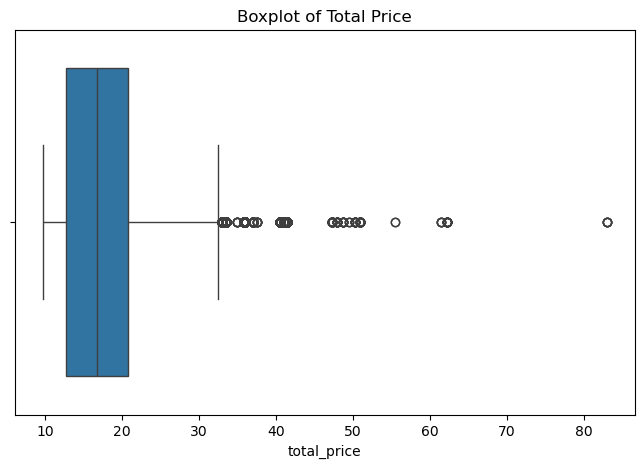

In [14]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

## Sales during holidays vs non-holidays

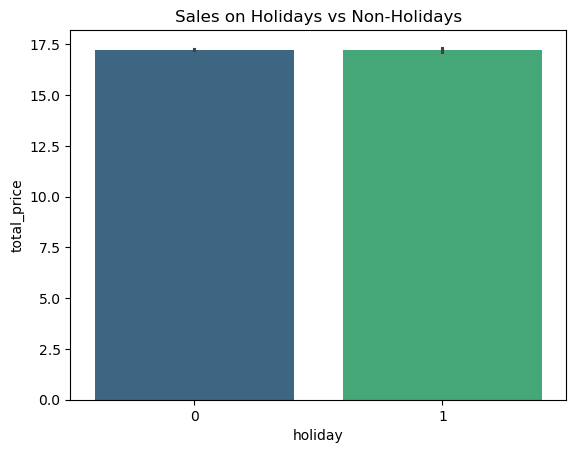

In [15]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

## Sales during promotions vs non-promotions

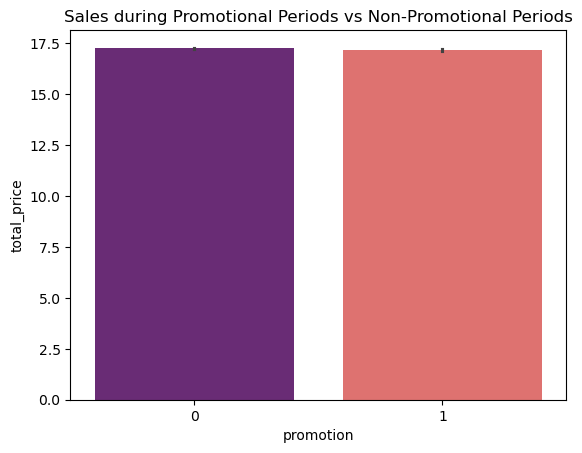

In [16]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

# 8. Model Selection

#### ARIMA / SARIMA ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are great starting points if your data shows seasonal patterns and trends.

In [17]:
pip install statsmodels

In [18]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


# ARIMA Model

##### p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
##### d (Differencing term): The number of times the data is differenced to make it stationary.
##### q (Moving Average term): The number of past forecast errors used to improve future predictions.

Best ARIMA Model MAPE: 0.1902, Best Parameters: (2, 0, 2)
Predictions:
order_date
2015-10-19    3372.957457
2015-10-26    3557.172595
2015-11-02    3689.325999
2015-11-09    3725.643337
2015-11-16    3698.322906
2015-11-23    3656.775349
2015-11-30    3631.359954
2015-12-07    3627.175406
2015-12-14    3634.984705
2015-12-21    3644.025723
2015-12-28    3648.703377
Name: predicted_mean, dtype: float64


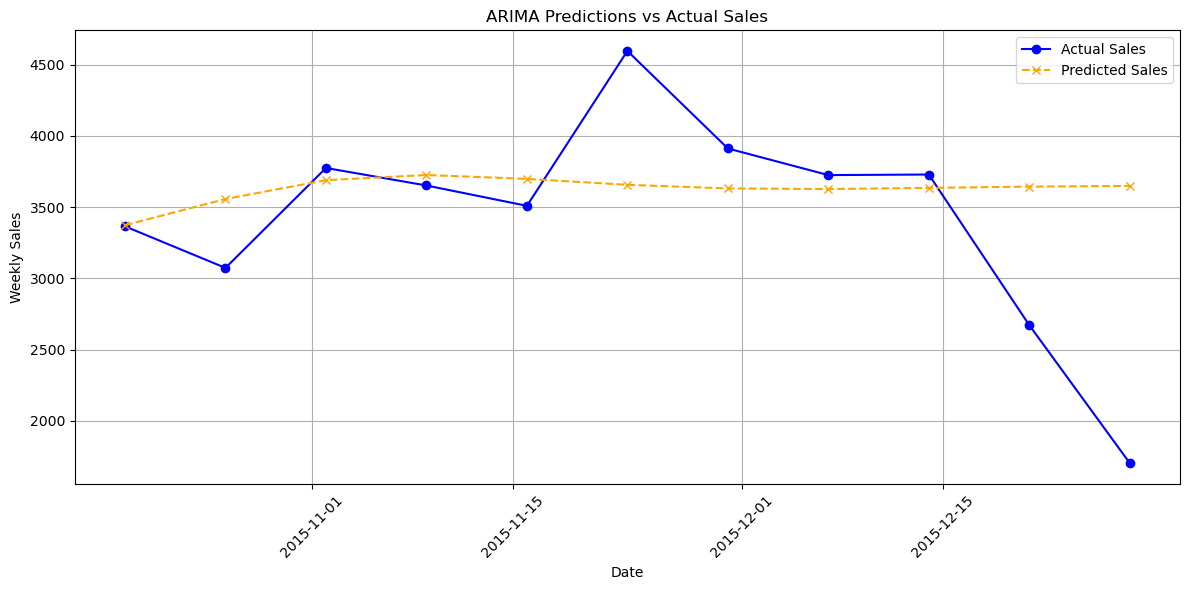

In [6]:
# Load your dataset (replace 'your_file.csv' with the actual filename)
pizza_sales = pd.read_csv("MERGED_DOMINOS_DATA.csv")

# Ensure 'order_date' column exists and is in datetime format
if 'order_date' not in pizza_sales.columns:
    raise KeyError("'order_date' column is missing from the dataset.")

pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'], errors='coerce')

# Drop rows where 'order_date' or 'quantity' is invalid
pizza_sales = pizza_sales.dropna(subset=['order_date', 'quantity'])

# Ensure 'quantity' is numeric
pizza_sales['quantity'] = pd.to_numeric(pizza_sales['quantity'], errors='coerce')
pizza_sales = pizza_sales.dropna(subset=['quantity'])

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# SARIMA (Seasonal ARIMA)

#### P (Seasonal AutoRegressive term): The number of past seasonal values used for prediction.
#### D (Seasonal Differencing term): The number of seasonal differencing applied to make data stationary.
#### Q (Seasonal Moving Average term): The number of past seasonal forecast errors used for prediction.
#### S (Seasonal Period): The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

Best SARIMA Model MAPE: 0.1849
Predictions:
order_date
2015-10-19    3251.125630
2015-10-26    3647.292260
2015-11-02    3407.561465
2015-11-09    2750.099063
2015-11-16    3590.353366
2015-11-23    3084.831395
2015-11-30    3327.425452
2015-12-07    3155.897000
2015-12-14    3475.639777
2015-12-21    3266.273805
2015-12-28    2592.941689
Name: predicted_mean, dtype: float64


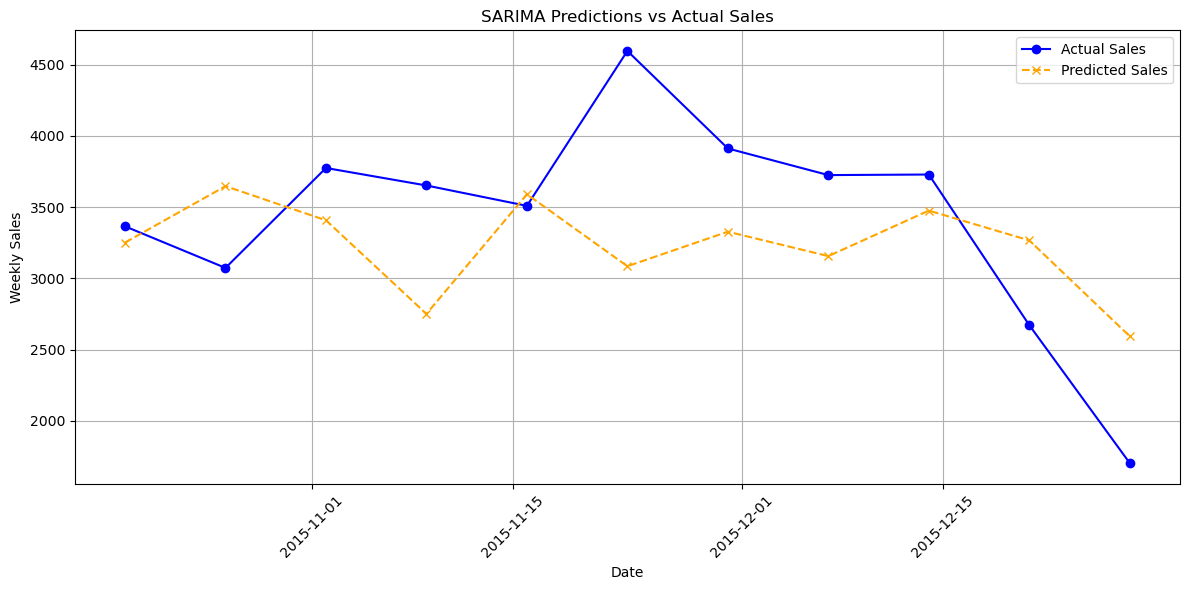

In [7]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Prophet (Developed by Facebook)

## Prophet is a popular model for handling time series data with seasonal and holiday effects.

### The Facebook Prophet model is a tool developed by Facebook for forecasting time series data. It’s especially useful when you want to predict future values based on historical data, such as sales, temperatures, or website traffic.

In [37]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


13:26:53 - cmdstanpy - INFO - Chain [1] start processing
13:26:54 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.1962
Predictions:
ds
2015-10-19    3619.506283
2015-10-26    3618.034527
2015-11-02    3616.562771
2015-11-09    3615.091015
2015-11-16    3613.619259
2015-11-23    3612.147503
2015-11-30    3610.675747
2015-12-07    3609.203991
2015-12-14    3607.732235
2015-12-21    3606.260479
2015-12-28    3604.788723
dtype: float64


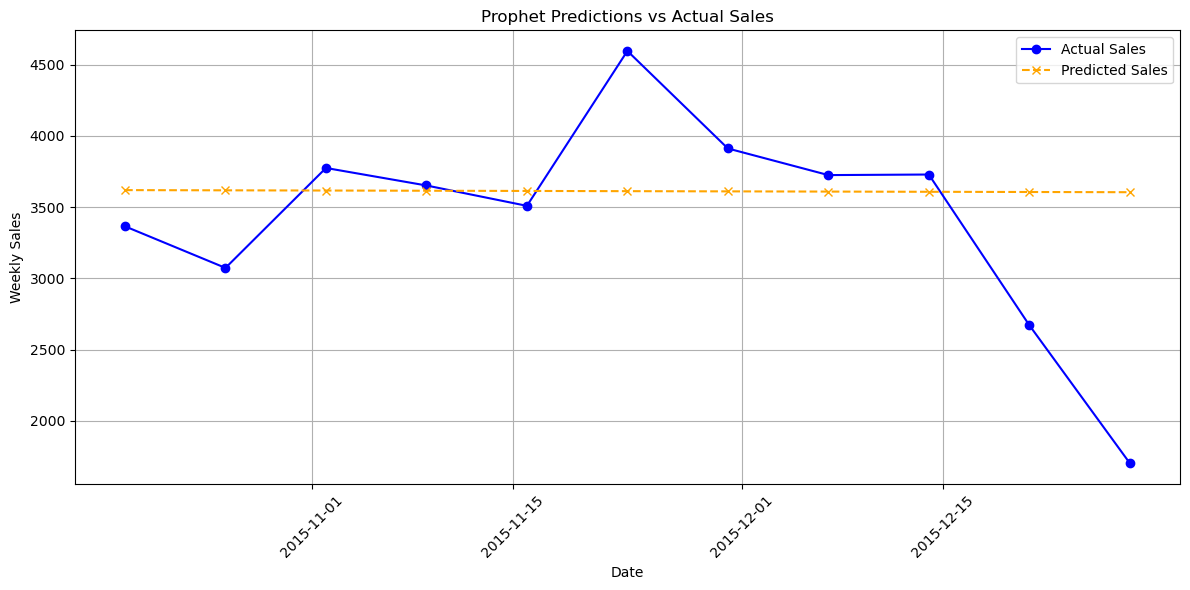

In [39]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Regression Model

Best Regression Model MAPE: 0.1911
Predictions:
order_date
2015-10-19    3545.287304
2015-10-26    3530.562085
2015-11-02    3552.361183
2015-11-09    3537.635964
2015-11-16    3522.910745
2015-11-23    3508.185526
2015-11-30    3493.460307
2015-12-07    3515.259404
2015-12-14    3500.534185
2015-12-21    3485.808966
2015-12-28    3471.083747
dtype: float64


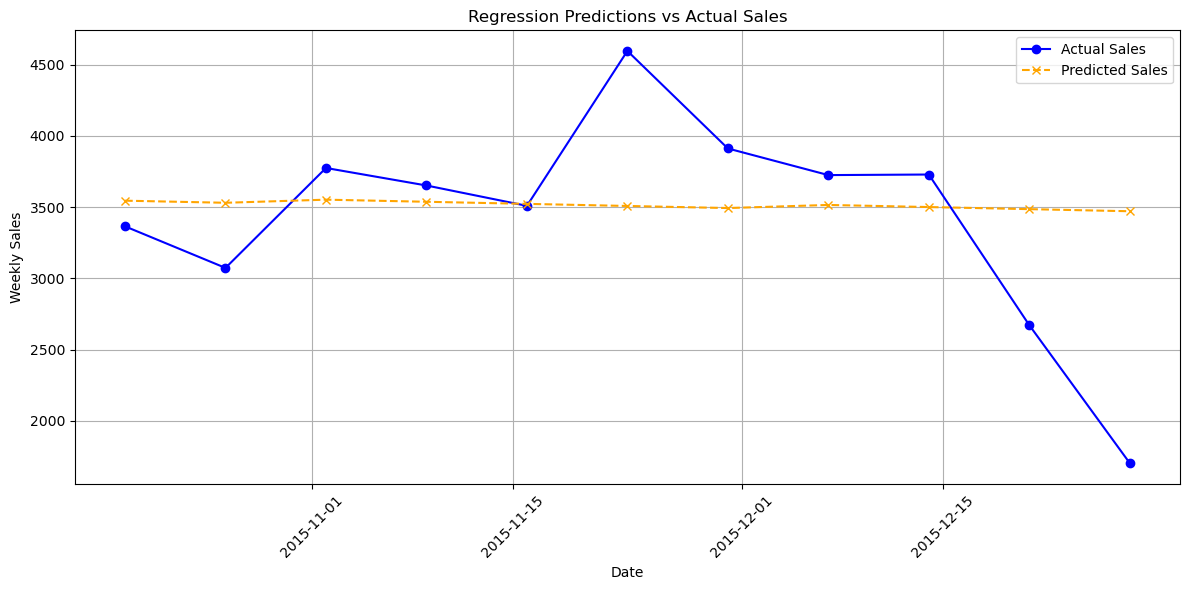

In [40]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    
    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# LSTM model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Best LSTM Model MAPE: 0.2354
Predictions:
order_date
2015-11-09    3447.690186
2015-11-16    3507.541016
2015-11-23    3652.433838
2015-11-30    3785.974365
2015-12-07    3888.616211
2015-12-14    4020.982178
2015-12-21    3753.014893
2015-12-28    3508.848145
dtype: float32


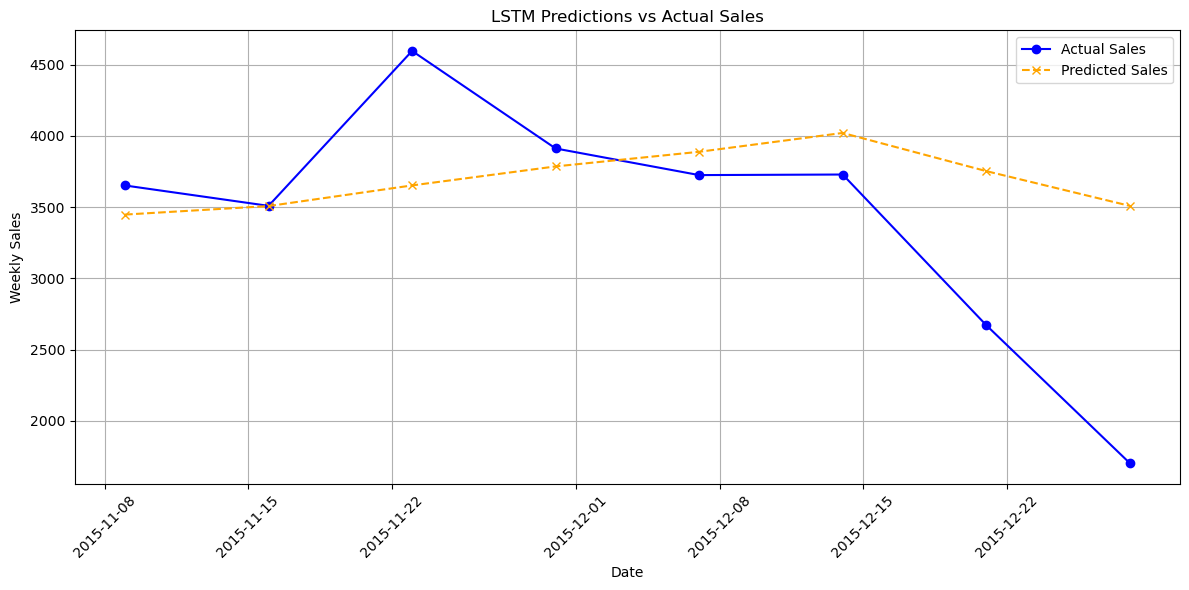

In [41]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Forecasted sales for the week

# ARIMA Model forecasted sales for the week:

In [31]:
# ARIMA Model forecasted sales for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 92 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 37 pizzas
calabrese_m: 43 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 80 pizzas
cali_ckn_m: 81 pizzas
cali_ckn_s: 39 pizzas
ckn_alfredo_l: 14 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 9 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 21 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 46 pizzas
five_cheese_l: 56 pizzas
four_cheese_l: 114 pizzas
four_cheese_m: 45 pizzas
green_garden_l: 10 pizzas
green_garden_m: 25 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 50 pizzas
hawaiian_m: 24 pizzas
hawaiian_s: 52 pizzas
ital_cpcllo_l: 55 pizzas
ital_cpcllo_m: 30 pizzas
ital_cpcllo_s: 23 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 66 pizzas
ital_supr_s: 14 pizzas
ital_veggie_l: 20 pizzas
ital_veggie_m: 36 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 36 pizzas
mediterraneo_m: 23 pizzas
mediterraneo_s

# SARIMA Model forecasted sales for the week:

In [43]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 82 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 39 pizzas
big_meat_s: 89 pizzas
brie_carre_s: 56 pizzas
calabrese_m: 40 pizzas
calabrese_s: 6 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 56 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 58 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 14 pizzas
classic_dlx_l: 19 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 39 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 149 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 3 pizzas
green_garden_m: 28 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 20 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 60 pizzas
ital_cpcllo_m: 37 pizzas
ital_cpcllo_s: 26 pizzas
ital_supr_l: 61 pizzas
ital_supr_m: 49 pizzas
ital_supr_s: 3 pizzas
ital_veggie_l: 16 pizzas
ital_veggie_m: 25 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 29 pizzas
mediterraneo_s: 1

# Prophet Evaluation

In [44]:
# Function to forecast sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})
    
    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)
    
    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

13:33:01 - cmdstanpy - INFO - Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing
13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:03 - cmdstanpy - INFO - Chain [1] done processing
13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:03 - cmdstanpy - INFO - Chain [1] done processing
13:33:03 - cmdstanpy - INFO - Chain [1] start processing
13:33:04 - cmdstanpy - INFO - Chain [1] done processing
13:33:04 - cmdstanpy - INFO - Chain [1] start processing
13:33:04 - cmdstanpy - INFO - Chain [1] done processing
13:33:04 - cmdstanpy - INFO - Chain [1] start processing
13:33:05 - cmdstanpy - INFO - Chain [1] done processing
13:33:05 - cmdstanpy - INFO - Chain [1] start processing
13:33:05 - cmdstanpy - INFO - Chain [1]

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 607 pizzas
bbq_ckn_m: 658 pizzas
bbq_ckn_s: 187 pizzas
big_meat_s: 766 pizzas
brie_carre_s: 275 pizzas
calabrese_m: 309 pizzas
calabrese_s: 55 pizzas
cali_ckn_l: 603 pizzas
cali_ckn_m: 563 pizzas
cali_ckn_s: 279 pizzas
ckn_alfredo_l: 111 pizzas
ckn_alfredo_m: 450 pizzas
ckn_alfredo_s: 70 pizzas
ckn_pesto_l: 218 pizzas
ckn_pesto_m: 165 pizzas
ckn_pesto_s: 149 pizzas
classic_dlx_l: 185 pizzas
classic_dlx_m: 520 pizzas
classic_dlx_s: 323 pizzas
five_cheese_l: 379 pizzas
four_cheese_l: 862 pizzas
four_cheese_m: 304 pizzas
green_garden_l: 77 pizzas
green_garden_m: 166 pizzas
green_garden_s: 362 pizzas
hawaiian_l: 385 pizzas
hawaiian_m: 208 pizzas
hawaiian_s: 366 pizzas
ital_cpcllo_l: 417 pizzas
ital_cpcllo_m: 180 pizzas
ital_cpcllo_s: 153 pizzas
ital_supr_l: 391 pizzas
ital_supr_m: 473 pizzas
ital_supr_s: 105 pizzas
ital_veggie_l: 94 pizzas
ital_veggie_m: 239 pizzas
ital_veggie_s: 98 pizzas
mediterraneo_l: 255 pizzas
mediter

# 9. Model Evaluation

### AIC (Akaike Information Criterion) is a statistical measure used for model comparison that quantifies the trade-off between model goodness of fit and complexity, with lower AIC values indicating better model performance.

In [8]:
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression', 'LSTM'],
    'MAPE': [0.1902, 0.1849, 0.1962, 0.1911, 0.2354],
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
1,SARIMA,0.1849,1.0,Best
0,ARIMA,0.1902,2.0,
3,Regression,0.1911,3.0,
2,Prophet,0.1962,4.0,
4,LSTM,0.2354,5.0,Worst


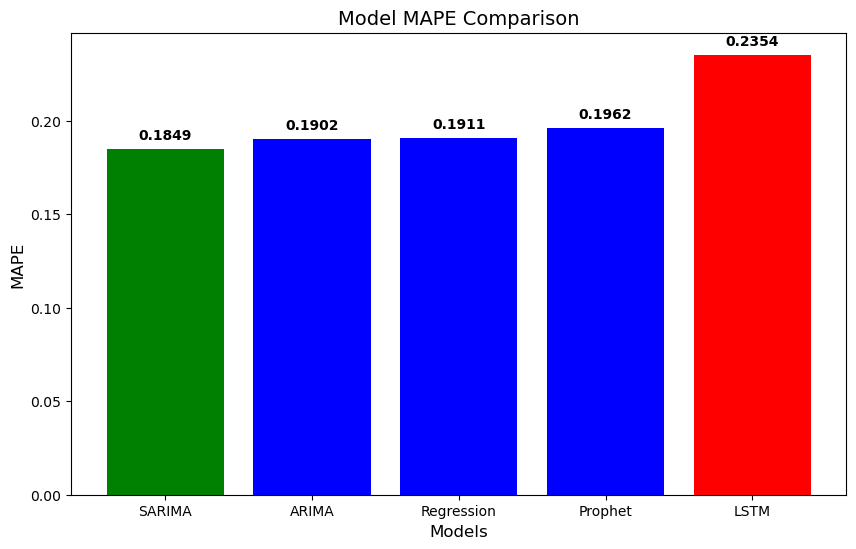

In [15]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1849, 0.1902, 0.1911, 0.1962, 0.2354]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()



# SARIMA Evaluation

In [16]:
# SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -249.196
Date:                           Tue, 19 Nov 2024   AIC                            508.391
Time:                                   11:21:09   BIC                            516.023
Sample:                               12-29-2014   HQIC                           510.994
                                    - 10-12-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3901      0.258     -1.514      0.130      -0.895       0.115
ma.L1         -0.4667      0.256     -1.826

# Hyperparameter Tuning for SARIMA

In [19]:
# Useing auto_arima to find the best parameters
auto_model = auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=511.689, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=514.308, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=505.442, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=505.959, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=505.737, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=506.854, Time=0.20 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=507.009, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=505.011, Time=0.11 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=507.009, Time=0.28 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=515.380, Time=0.09 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=506.879, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=506.392, Time=0.18 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=508.027, Time=0.22 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=505.395, 

# Saving the Model Using pickle

In [21]:
import pickle # Importing pickle for saving the model

# Save the model to a file using pickle
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_sarima_model.pkl


In [22]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.


# 10. Final Results and Predictions

In [23]:
# Loading the model
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Forecasting function
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=7)
print(forecasted_sales)

2015-10-19    3213.580075
2015-10-26    3760.607880
2015-11-02    3370.263291
2015-11-09    2900.604061
2015-11-16    3582.850125
2015-11-23    3194.747226
2015-11-30    3349.252533
Freq: W-MON, dtype: float64


# Forecasting Report Visulazation

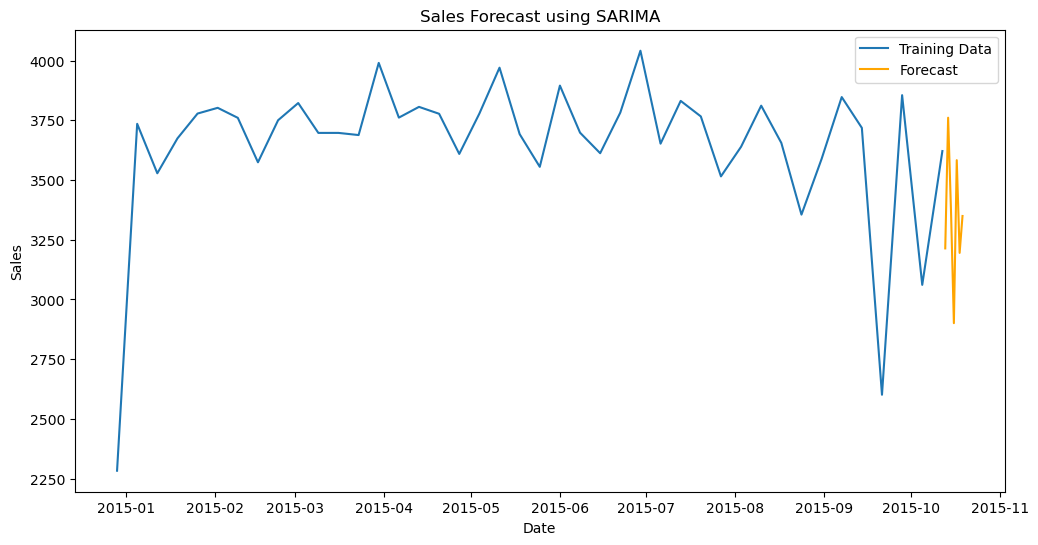

In [24]:
# Loading the best model
with open('best_sarima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Forecasting the data
n_forecast = 7
forecast = best_model.predict(n_periods=n_forecast)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_forecast), forecast, label='Forecast', color='orange')
plt.title('Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [32]:
Ingredients_dataset = pd.read_csv("Ingredients_dataset.csv")
# Displaying the total quantity of predicted ingredients

# Displaying the total quantity of predicted ingredients

# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2540.0, 'Alfredo Sauce': 1285.0, 'Anchovies': 3295.0, 'Artichokes': 10485.0, 'Arugula': 705.0, 'Asiago Cheese': 6200.0, 'Bacon': 28670.0, 'Barbecue Sauce': 2425.0, 'Barbecued Chicken': 6950.0, 'Beef Chuck Roast': 10660.0, 'Blue Cheese': 1680.0, 'Brie Carre Cheese': 1110.0, 'Calabrese Salami': 15100.0, 'Capocollo': 62100.0, 'Caramelized Onions': 592.0, 'Chicken': 80800.0, 'Chipotle Sauce': 7330.0, 'Chorizo Sausage': 5350.0, 'Cilantro': 3665.0, 'Coarse Sicilian Salami': 11480.0, 'Corn': 24540.0, 'Eggplant': 2960.0, 'Feta Cheese': 9970.0, 'Fontina Cheese': 5840.0, 'Friggitello Peppers': 635.0, 'Garlic': 23835.0, 'Genoa Salami': 8790.0, 'Goat Cheese': 12940.0, 'Gorgonzola Piccante Cheese': 5460.0, 'Gouda Cheese': 4410.0, 'Green Olives': 4745.0, 'Green Peppers': 6840.0, 'Italian Sausage': 1070.0, 'Jalapeno Peppers': 5870.0, 'Kalamata Olives': 3070.0, 'Luganega Sausage': 5740.0, 'Mozzarella Cheese': 11560.0, 'Mu

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,92,3680.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,92,1380.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,92,1840.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,92,2760.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,92,5520.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,33,660.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,33,660.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,33,330.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,33,495.0


In [33]:
ingredient_totals

{'?duja Salami': 2540.0,
 'Alfredo Sauce': 1285.0,
 'Anchovies': 3295.0,
 'Artichokes': 10485.0,
 'Arugula': 705.0,
 'Asiago Cheese': 6200.0,
 'Bacon': 28670.0,
 'Barbecue Sauce': 2425.0,
 'Barbecued Chicken': 6950.0,
 'Beef Chuck Roast': 10660.0,
 'Blue Cheese': 1680.0,
 'Brie Carre Cheese': 1110.0,
 'Calabrese Salami': 15100.0,
 'Capocollo': 62100.0,
 'Caramelized Onions': 592.0,
 'Chicken': 80800.0,
 'Chipotle Sauce': 7330.0,
 'Chorizo Sausage': 5350.0,
 'Cilantro': 3665.0,
 'Coarse Sicilian Salami': 11480.0,
 'Corn': 24540.0,
 'Eggplant': 2960.0,
 'Feta Cheese': 9970.0,
 'Fontina Cheese': 5840.0,
 'Friggitello Peppers': 635.0,
 'Garlic': 23835.0,
 'Genoa Salami': 8790.0,
 'Goat Cheese': 12940.0,
 'Gorgonzola Piccante Cheese': 5460.0,
 'Gouda Cheese': 4410.0,
 'Green Olives': 4745.0,
 'Green Peppers': 6840.0,
 'Italian Sausage': 1070.0,
 'Jalapeno Peppers': 5870.0,
 'Kalamata Olives': 3070.0,
 'Luganega Sausage': 5740.0,
 'Mozzarella Cheese': 11560.0,
 'Mushrooms': 25860.0,
 'Onions

<Figure size 2500x1500 with 0 Axes>

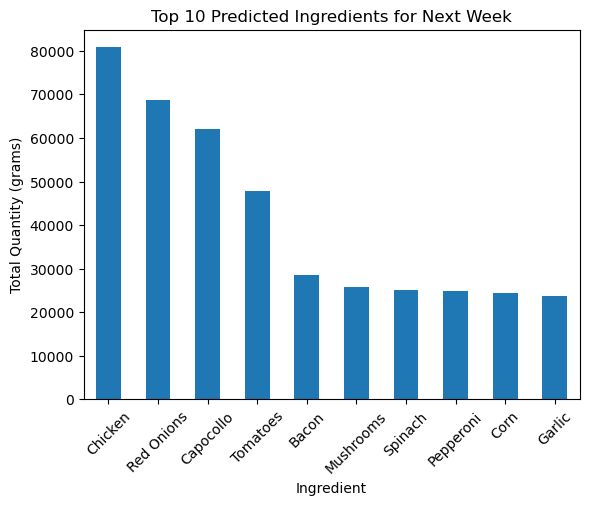

In [41]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(25, 15))
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(kind='bar', x='Ingredient', y='Total Quantity (grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()

In [37]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [42]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2540.0
1,Alfredo Sauce,1285.0
2,Anchovies,3295.0
3,Artichokes,10485.0
4,Arugula,705.0
...,...,...
59,Sun-dried Tomatoes,1490.0
60,Thai Sweet Chilli Sauce,4170.0
61,Thyme,185.0
62,Tomatoes,47840.0
